In [3]:
import pandas as pd
papers = pd.read_csv('abcnews-date-text.csv', error_bad_lines=False);

In [4]:
papers.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [5]:
# Remove the columns
papers = papers.drop(columns=['publish_date'], axis=1)
# sample only 10 papers - for demonstration purposes
papers = papers.sample(1000)
# Print out the first rows of papers
papers.head()

,headline_text
778331,wine lovers to toast end of vintage
46924,council to mediate in orphanage redevelopment row
451406,sylvia plaths son commits suicide
1159021,dominic thiem stuns roger federer at indian wells
158239,scientists hail new drug


In [6]:
# Load the regular expression library
import re
# Remove punctuation
papers['paper_text_processed'] = papers['headline_text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
papers['paper_text_processed'] = papers['headline_text'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['paper_text_processed'].head()

778331                   wine lovers to toast end of vintage
46924      council to mediate in orphanage redevelopment row
451406                     sylvia plaths son commits suicide
1159021    dominic thiem stuns roger federer at indian wells
158239                              scientists hail new drug
Name: paper_text_processed, dtype: object

In [7]:
%%time
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:2])

[['wine', 'lovers', 'to', 'toast', 'end', 'of', 'vintage'], ['council', 'to', 'mediate', 'in', 'orphanage', 'redevelopment', 'row']]
Wall time: 2.06 s


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:5])

[['wine', 'lover', 'toast', 'end', 'vintage'], ['redevelopment', 'row'], ['son', 'commit', 'suicide'], ['well'], ['scientist', 'hail', 'new', 'drug']]


In [12]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(5, 1), (6, 1)], [(7, 1), (8, 1), (9, 1)], [(10, 1)], [(11, 1), (12, 1), (13, 1), (14, 1)], [(15, 1), (16, 1), (17, 1), (18, 1), (19, 1)], [(20, 1), (21, 1), (22, 1), (23, 1), (24, 1)], [(25, 1), (26, 1), (27, 1)], [], [(28, 1), (29, 1), (30, 1), (31, 1)], [(32, 1), (33, 1), (34, 1), (35, 1)], [(36, 1), (37, 1), (38, 1)], [(39, 1), (40, 1), (41, 1)], [], [(42, 1), (43, 1), (44, 1), (45, 1)], [(46, 1), (47, 1), (48, 1)], [(49, 1), (50, 1), (51, 1)], [(52, 1), (53, 1), (54, 1)], [(55, 1), (56, 1), (57, 1), (58, 1), (59, 1)], [(60, 1), (61, 1), (62, 1)], [(63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1)], [(69, 1), (70, 1), (71, 1)], [(72, 1), (73, 1), (74, 1)], [(38, 1), (75, 1), (76, 1), (77, 1), (78, 1)], [(79, 1), (80, 1)], [(81, 1), (82, 1)], [(83, 1), (84, 1), (85, 1)], [(86, 1), (87, 1), (88, 1), (89, 1)], [], [(90, 1), (91, 1)], [(92, 1), (93, 1), (94, 1)], [(47, 1), (95, 1), (96, 1)], [(81, 1), (97, 1), (98, 1), (99, 1), (100, 1)], 

In [13]:
print(id2word)
print(id2word[308])

Dictionary(1689 unique tokens: ['end', 'lover', 'toast', 'vintage', 'wine']...)
final


In [14]:

print(corpus[3])
print(id2word[12])
print(id2word[13])
print(id2word[14])

[(10, 1)]
hail
new
scientist


In [76]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [77]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.037*"new" + 0.015*"water" + 0.014*"rural" + 0.012*"woman" + 0.010*"may" + '
  '0.009*"tourism" + 0.008*"storm" + 0.008*"country" + 0.008*"announce" + '
  '0.008*"student"'),
 (1,
  '0.025*"police" + 0.017*"offer" + 0.016*"man" + 0.012*"say" + 0.009*"study" '
  '+ 0.009*"charge" + 0.009*"hear" + 0.009*"pay" + 0.009*"ban" + 0.008*"turn"'),
 (2,
  '0.017*"say" + 0.017*"fire" + 0.016*"cut" + 0.012*"death" + 0.011*"rudd" + '
  '0.011*"man" + 0.010*"fatal" + 0.010*"decision" + 0.008*"power" + '
  '0.008*"first"'),
 (3,
  '0.010*"plan" + 0.009*"car" + 0.008*"say" + 0.008*"leave" + 0.008*"mining" + '
  '0.008*"rule" + 0.007*"gas" + 0.007*"investment" + 0.007*"survivor" + '
  '0.007*"farmer"'),
 (4,
  '0.037*"face" + 0.015*"service" + 0.014*"sale" + 0.011*"find" + 0.010*"take" '
  '+ 0.010*"suicide" + 0.009*"rise" + 0.008*"park" + 0.008*"concern" + '
  '0.007*"troop"'),
 (5,
  '0.029*"charge" + 0.011*"flood" + 0.011*"continue" + 0.010*"set" + '
  '0.010*"market" + 0.009*"question" + 0

In [18]:
#the baseline coherence score
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.732688278173474


In [19]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [80]:

import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]

corpus_title = ['100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [43:16<00:00, 10.82s/it]


In [81]:
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        #for k in topics_range:
            # iterate through alpha values
        for a in alpha:
             # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=10, a=a, b=b)
                    # Save the model results
                model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results10.csv', index=False)
    pbar.close()

 12%|██████████▏                                                                      | 30/240 [05:09<36:04, 10.31s/it]


In [20]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.31)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.72995253404164


In [21]:
from pprint import pprint

# Print the Keyword in the 2 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"new" + 0.006*"water" + 0.006*"price" + 0.005*"man" + 0.005*"find" + '
  '0.005*"child" + 0.005*"people" + 0.004*"fire" + 0.004*"race" + '
  '0.004*"care"'),
 (1,
  '0.007*"police" + 0.007*"kill" + 0.006*"time" + 0.006*"crash" + 0.006*"man" '
  '+ 0.006*"say" + 0.005*"car" + 0.005*"urge" + 0.005*"new" + 0.005*"accuse"')]


In [22]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.117926  0.0       1        1  51.684349
1     -0.117926  0.0       2        1  48.315651, topic_info=       Term       Freq      Total Category  logprob  loglift
381    time   9.000000   9.000000  Default  30.0000  30.0000
135   price  10.000000  10.000000  Default  29.0000  29.0000
249  accuse   8.000000   8.000000  Default  28.0000  28.0000
260    road   8.000000   8.000000  Default  27.0000  27.0000
72    child   9.000000   9.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
13      new   8.389819  21.915485   Topic2  -5.2859  -0.2328
119  charge   6.451508  12.961699   Topic2  -5.5486   0.0297
506   woman   5.302885   7.990476   Topic2  -5.7446   0.3174
74     warn   5.380814   8.686979   Topic2  -5.7301   0.2484
16     find   5.560032  14.472539   Topic2  -5.6973  -0.2292

[128 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
249       2  0.933796   accuse
496       1  1.034023   action
28        1  0.914249    ahead
127       2  0.966502   appeal
818       1  0.850724  assault
...     ...       ...      ...
89        2  0.754077      win
506       1  0.375447    woman
506       2  0.625745    woman
348       2  1.024223   worker
339       1  1.022962     year

[125 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [30]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(50)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9980,"new, water, price, man, find, child, people, f...","[wine, lover, toast, end, vintage]"
1,1,1.0,0.9950,"police, kill, time, crash, man, say, car, urge...","[redevelopment, row]"
2,2,1.0,0.9967,"police, kill, time, crash, man, say, car, urge...","[son, commit, suicide]"
3,3,0.0,0.9902,"new, water, price, man, find, child, people, f...",[well]
4,4,0.0,0.9975,"new, water, price, man, find, child, people, f...","[scientist, hail, new, drug]"
5,5,1.0,0.9980,"police, kill, time, crash, man, say, car, urge...","[consider, surveillance, find, nigerian, girl]"
6,6,0.0,0.9980,"new, water, price, man, find, child, people, f...","[report, forecast, hunter, job, growth]"
7,7,1.0,0.9967,"police, kill, time, crash, man, say, car, urge...","[week, hand, injury]"
8,8,0.0,0.5000,"new, water, price, man, find, child, people, f...",[]
9,9,0.0,0.9975,"new, water, price, man, find, child, people, f...","[pressure, ahead, debate, rematch]"


In [20]:
from gensim.models import CoherenceModel
from pprint import pprint
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=3, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)
pprint(lda_model.print_topics())

Coherence Score:  0.7205158331920313
[(0,
  '0.009*"fire" + 0.007*"attack" + 0.007*"call" + 0.006*"find" + 0.006*"take" '
  '+ 0.006*"cut" + 0.006*"market" + 0.006*"death" + 0.005*"report" + '
  '0.005*"year"'),
 (1,
  '0.020*"police" + 0.010*"urge" + 0.009*"say" + 0.008*"kill" + 0.006*"crash" '
  '+ 0.006*"accuse" + 0.006*"new" + 0.006*"defend" + 0.005*"leader" + '
  '0.005*"plan"'),
 (2,
  '0.013*"charge" + 0.013*"man" + 0.010*"court" + 0.009*"woman" + 0.009*"jail" '
  '+ 0.008*"murder" + 0.008*"drug" + 0.007*"plan" + 0.006*"accident" + '
  '0.006*"new"')]


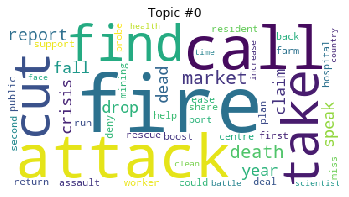

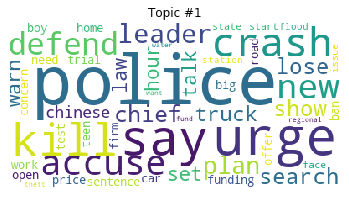

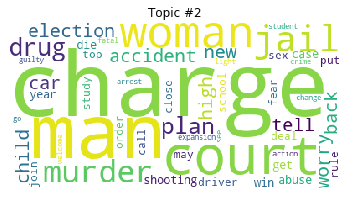

In [33]:
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud
for t in range(lda_model.num_topics):
    plt.figure()
    #plt.imshow(WordCloud().fit_words(lda_model.show_topic(t, 200)))
    plt.imshow(WordCloud(background_color='white').fit_words(dict(lda_model.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [45]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=corpus, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

NameError: name 'vectorizer' is not defined

In [48]:
for i, row in enumerate(lda_model[corpus]):
    row = sorted(row, key=lambda x:x[1], reverse=True)
    print(row)

[(0, 0.99800736)]
[(1, 0.9950477)]
[(1, 0.9966877)]
[(0, 0.9901948)]
[(0, 0.9975121)]
[(1, 0.99800754)]
[(0, 0.9980076)]
[(1, 0.9966881)]
[(0, 0.5), (1, 0.5)]
[(0, 0.9975119)]
[(1, 0.997512)]
[(1, 0.99668825)]
[(0, 0.99668795)]
[(0, 0.5), (1, 0.5)]
[(1, 0.99751186)]
[(0, 0.9966878)]
[(1, 0.9966882)]
[(0, 0.9966882)]
[(1, 0.9980073)]
[(0, 0.9966884)]
[(1, 0.99833846)]
[(1, 0.99668753)]
[(0, 0.99668854)]
[(1, 0.99800766)]
[(0, 0.99504805)]
[(1, 0.995049)]
[(0, 0.9966882)]
[(1, 0.997512)]
[(0, 0.5), (1, 0.5)]
[(1, 0.9950477)]
[(1, 0.99668807)]
[(0, 0.9966878)]
[(1, 0.9980077)]
[(1, 0.9901924)]
[(0, 0.5), (1, 0.5)]
[(1, 0.9980075)]
[(0, 0.9975122)]
[(0, 0.9901954)]
[(0, 0.99800736)]
[(1, 0.99751157)]
[(0, 0.6712144), (1, 0.32878557)]
[(0, 0.9975116)]
[(1, 0.9980076)]
[(0, 0.99833846)]
[(0, 0.99857503)]
[(0, 0.5), (1, 0.5)]
[(1, 0.99800754)]
[(0, 0.9966884)]
[(0, 0.9901923)]
[(0, 0.9985753)]
[(0, 0.9975118)]
[(0, 0.9975119)]
[(0, 0.9975119)]
[(0, 0.9980075)]
[(0, 0.997512)]
[(1, 0.9950491)]

[(0, 0.99800766)]
[(0, 0.99751204)]
[(1, 0.997512)]
[(1, 0.997512)]
[(0, 0.995049)]
[(1, 0.99833864)]
[(0, 0.58495486), (1, 0.41504514)]
[(1, 0.99751204)]
[(1, 0.9980076)]
[(0, 0.99751216)]
[(0, 0.9966882)]
[(0, 0.99019396)]
[(0, 0.9980076)]
[(1, 0.8220471), (0, 0.17795287)]
[(1, 0.9950489)]
[(1, 0.99751204)]
[(0, 0.9983386)]
[(1, 0.997512)]
[(1, 0.9983386)]
[(0, 0.9966881)]
[(1, 0.9985752)]
[(0, 0.99875283)]
[(1, 0.9966883)]
[(1, 0.99751204)]
[(0, 0.5), (1, 0.5)]
[(1, 0.9983387)]
[(1, 0.9975119)]
[(0, 0.99504924)]
[(0, 0.9975114)]
[(0, 0.99504775)]
[(1, 0.99504906)]
[(0, 0.9983384)]
[(0, 0.99751174)]
[(0, 0.99800736)]
[(0, 0.6333164), (1, 0.36668363)]
[(1, 0.99668825)]
[(1, 0.9950482)]
[(1, 0.9950478)]
[(0, 0.9901951)]
[(1, 0.99833834)]
[(1, 0.9980075)]
[(1, 0.9975116)]
[(0, 0.9950481)]
[(0, 0.5), (1, 0.5)]
[(0, 0.66832906), (1, 0.331671)]
[(0, 0.99800724)]
[(0, 0.99504805)]
[(1, 0.9980071)]
[(1, 0.9950483)]
[(1, 0.73216486), (0, 0.2678351)]
[(0, 0.9950493)]
[(0, 0.9975116)]
[(0, 0.5)